In [2]:
import pandas as pd
import numpy as np
import re
import gensim
from pythainlp.tokenize import word_tokenize
from pythainlp.corpus import thai_stopwords
from wordcloud import WordCloud
from gensim import corpora, models, similarities
import pyLDAvis
from pprint import pprint
import pickle 
import os
import matplotlib.pyplot as plt
from gensim.models import CoherenceModel
from gensim.test.utils import datapath
import random
from gensim.models.ldamodel import LdaModel
import sklearn
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from gensim.corpora import MmCorpus
import csv
import pyLDAvis.gensim_models as gensimvis
from sklearn import metrics
RANDOM_STATE = 1

In [3]:
data = pd.read_csv('dataset/DatasetLegal.csv')
# train_data = pd.read_csv('model/train_data.csv')
# test_data = pd.read_csv('model/test_data.csv')
with open("model/train_data.csv", 'r') as f:
  train_data_csv = csv.reader(f)
  train_data = [i for i in train_data_csv]
with open("model/test_data.csv", 'r') as f:
  test_data_csv = csv.reader(f)
  test_data = [i for i in test_data_csv]
with open('model/id2word.pkl', 'rb') as f:
   id2word = pickle.load(f)
corpus = []
for text in train_data:
  vec = id2word.doc2bow(text)
  corpus.append(vec)
pd.Series(corpus)
with open("model/topic_dict.pkl", "rb") as f:
   topic_dict = pickle.load(f)
with open("model/lda_model.pkl", "rb") as f:
   lda_model = pickle.load(f)

import logging
logging.basicConfig(filename='model_callbacks.log',
                    format="%(asctime)s:%(levelname)s:%(message)s",
                    level=logging.NOTSET)

from gensim.models.callbacks import PerplexityMetric, CoherenceMetric
perplexity_logger = PerplexityMetric(corpus=corpus, logger='shell')
coherence_cv_logger = CoherenceMetric(corpus=corpus, logger='shell', coherence = 'c_v', texts = train_data)

with open("model/corpus_question.pkl", "rb") as f:
   corpus_question = pickle.load(f)
with open("model/corpus_answer.pkl", "rb") as f:
   corpus_answer = pickle.load(f)

corpus_question_train = corpus_question[:5625]
corpus_question_test = corpus_question[5625:]
corpus_answer_train = corpus_answer[:5625]
corpus_answer_test = corpus_answer[5625:]

In [4]:
str_answer = data['answer'].astype(str)
str_answer = str_answer.map(lambda x: re.sub('[,.!?*#/]', '', x))
str_question = data['question'].astype(str)
str_question = str_question.map(lambda x: re.sub('[,.!?*#/]', '', x))
sentense_token_question = []
sentense_token_answer = []
for i in range(len(str_answer)):
  sentense_token_question.append(str_question[i])
  sentense_token_answer.append(str_answer[i])
word_token_question = []
word_token_answer = []
for i in range(len(sentense_token_question)):
  words_question = word_tokenize(sentense_token_question[i], engine='newmm') 
  words_answer = word_tokenize(sentense_token_answer[i], engine='newmm') 
  word_token_question.append(words_question)
  word_token_answer.append(words_answer)

stopwords = list(thai_stopwords())
read_stopwords = pd.read_csv('dataset/add_stopwords.csv')
add_stopwords = read_stopwords['stopword'].values.tolist()
processed_question = []
for sentense in word_token_question:
  each_sentense = []
  for word in sentense:
    if(word not in stopwords + add_stopwords):
      each_sentense.append(word)
  processed_question.append(each_sentense)
processed_answer = []
for sentense in word_token_answer:
  each_sentense = []
  for word in sentense:
    if(word not in stopwords + add_stopwords):
      each_sentense.append(word)
  processed_answer.append(each_sentense)
corpus_question = []
for text in processed_question:
  vec = id2word.doc2bow(text)
  corpus_question.append(vec)
pd.Series(corpus_question)
corpus_answer = []
for text in processed_answer:
  vec = id2word.doc2bow(text)
  corpus_answer.append(vec)
pd.Series(corpus_answer)
with open('model/corpus_question.pkl', 'wb') as f:
    pickle.dump(corpus_question, f)
with open('model/corpus_answer.pkl', 'wb') as f:
    pickle.dump(corpus_answer, f)

In [5]:
pred_question_score = [lda_model[text] for text in corpus_question_train]
pred_answer_score = [lda_model[text] for text in corpus_answer_train]
pred_answer_score

[[(0, 0.15819298),
  (1, 0.061972823),
  (2, 0.7787106),
  (3, 0.0005905947),
  (4, 0.00053297845)],
 [(0, 0.0013535123),
  (1, 0.0016944035),
  (2, 0.9947641),
  (3, 0.0011500968),
  (4, 0.0010378975)],
 [(0, 0.00046010094),
  (1, 0.9982166),
  (2, 0.0005795013),
  (3, 0.00039095365),
  (4, 0.00035281363)],
 [(0, 0.0020948662),
  (1, 0.0026224402),
  (2, 0.99189633),
  (3, 0.0017800347),
  (4, 0.001606381)],
 [(0, 0.00044576888),
  (1, 0.0005580343),
  (2, 0.018024024),
  (3, 0.98063034),
  (4, 0.00034182356)],
 [(0, 0.0010729107),
  (1, 0.48367864),
  (2, 0.001351336),
  (3, 0.000911666),
  (4, 0.51298547)],
 [(0, 0.0014551661),
  (1, 0.9943597),
  (2, 0.001832789),
  (3, 0.0012364733),
  (4, 0.0011158475)],
 [(0, 0.14520635),
  (1, 0.85025537),
  (2, 0.0019874729),
  (3, 0.0013408262),
  (4, 0.00121002)],
 [(0, 0.0010342182),
  (1, 0.0012946792),
  (2, 0.9959992),
  (3, 0.0008787886),
  (4, 0.00079305714)],
 [(0, 0.0068926094),
  (1, 0.008628552),
  (2, 0.008681259),
  (3, 0.0058567

In [6]:
threshold = 1/len(topic_dict)
num_topics = len(topic_dict)
threshold

0.2

In [7]:
question_predict=[]
for each_topic in pred_question_score:
  temp_pred = []
  for topic in each_topic:
    if(topic[1]>threshold): temp_pred.append(1)
    else: temp_pred.append(0)
  question_predict.append(temp_pred)
pd.DataFrame(question_predict)

,0,1,2,3,4
0,0,0,1,0,0
1,0,0,1,0,0
2,0,1,0,0,0
3,0,0,1,0,0
4,1,0,0,1,0
...,...,...,...,...,...
5620,1,1,0,1,0
5621,0,1,0,1,0
5622,0,0,0,1,1
5623,0,0,1,0,1


In [8]:
answer_predict=[]
for each_topic in pred_answer_score:
  temp_pred = []
  for topic in each_topic:
    if(topic[1]>threshold) : temp_pred.append(1)
    else: temp_pred.append(0)
  answer_predict.append(temp_pred)
pd.DataFrame(answer_predict)

,0,1,2,3,4
0,0,0,1,0,0
1,0,0,1,0,0
2,0,1,0,0,0
3,0,0,1,0,0
4,0,0,0,1,0
...,...,...,...,...,...
5620,0,1,0,0,0
5621,0,1,0,0,1
5622,0,1,0,0,1
5623,0,1,1,0,0


In [9]:
y_true = np.array(answer_predict)
y_pred = np.array(question_predict)

In [10]:
topic_true_0 = [sublist[1] for sublist in y_true]
topic_true_1 = [sublist[0] for sublist in y_true]
topic_true_2 = [sublist[2] for sublist in y_true]
topic_true_3 = [sublist[3] for sublist in y_true]
topic_true_4 = [sublist[4] for sublist in y_true]

topic_pred_0 = [sublist[1] for sublist in y_pred]
topic_pred_1 = [sublist[0] for sublist in y_pred]
topic_pred_2 = [sublist[2] for sublist in y_pred]
topic_pred_3 = [sublist[3] for sublist in y_pred]
topic_pred_4 = [sublist[4] for sublist in y_pred]

In [11]:
print(f'accuracy for topic {topic_dict[0]} : {metrics.accuracy_score(topic_true_0, topic_pred_0):.2f}')
print(f'accuracy for topic {topic_dict[1]} : {metrics.accuracy_score(topic_true_1, topic_pred_1):.2f}')
print(f'accuracy for topic {topic_dict[2]} : {metrics.accuracy_score(topic_true_2, topic_pred_2):.2f}')
print(f'accuracy for topic {topic_dict[3]} : {metrics.accuracy_score(topic_true_3, topic_pred_3):.2f}')
print(f'accuracy for topic {topic_dict[4]} : {metrics.accuracy_score(topic_true_4, topic_pred_4):.2f}')
# print(f'accuracy for topic {topic_dict[5]} : {metrics.accuracy_score(topic_true_5, topic_pred_5):.2f}')


accuracy for topic labor : 0.69
accuracy for topic personal right/court : 0.91
accuracy for topic family/succession : 0.93
accuracy for topic contract : 0.73
accuracy for topic criminal : 0.75


In [12]:
metrics.multilabel_confusion_matrix(y_true, y_pred)

array([[[4159,  229],
        [ 283,  954]],

       [[2724,  205],
        [1541, 1155]],

       [[3488,  162],
        [ 224, 1751]],

       [[3283, 1360],
        [ 177,  805]],

       [[3746, 1288],
        [ 146,  445]]], dtype=int64)

In [13]:
label_names = list(topic_dict.values())
print(metrics.classification_report(y_true, y_pred,target_names=label_names))

                      precision    recall  f1-score   support

               labor       0.81      0.77      0.79      1237
personal right/court       0.85      0.43      0.57      2696
   family/succession       0.92      0.89      0.90      1975
            contract       0.37      0.82      0.51       982
            criminal       0.26      0.75      0.38       591

           micro avg       0.61      0.68      0.65      7481
           macro avg       0.64      0.73      0.63      7481
        weighted avg       0.75      0.68      0.67      7481
         samples avg       0.66      0.73      0.66      7481



In [14]:
y_true = answer_predict
y_pred = question_predict

count_true = 0
count_false = 0
pred_list = []
true_list = []
checker = False
for i in range(len(y_true)):
    checker = False
    for j in range(len(y_true[i])):
        if(y_true[i][j] == 1):
            if(y_true[i][j] == y_pred[i][j]):
                checker = True
    if(checker == True):
        count_true += 1
        pred_list.append(y_pred[i])
        true_list.append(y_true[i])
    if(checker == False):
        count_false += 1
print(f'count_true = {count_true} docs\ncount_false = {count_false} docs')
print(f"accuracy = {count_true/(count_true+count_false):.2f}")

count_true = 4691 docs
count_false = 934 docs
accuracy = 0.83


accuracy (bleu) = 0.80


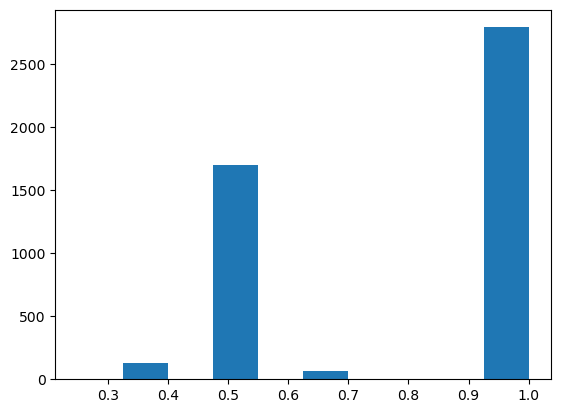

In [15]:
# calculate accuracy -> if answer is not as same as question, that one is false -> bleu
accuracy_list_bleu = []
for i in range(len(pred_list)):
    count = 0
    check = 0
    for j in range(num_topics):
        if(pred_list[i][j]==1):
            count += 1
            if(true_list[i][j]==1):
                check += 1
    accuracy_list_bleu.append(check/count)
avg_acc_list_2 = sum(accuracy_list_bleu)/len(pred_list)
print(f"accuracy (bleu) = {avg_acc_list_2:.2f}")
plt.hist(accuracy_list_bleu)
plt.show()

accuracy (rouge) = 0.87


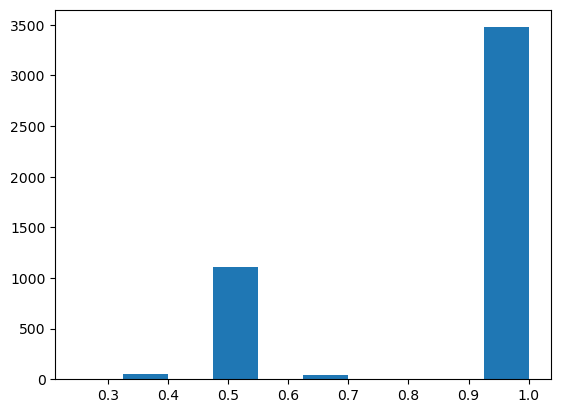

In [16]:
# calculate accuracy -> if question is not as same as answer, that one is false -> rouge
accuracy_list_rouge = []
for i in range(len(pred_list)):
    count = 0
    check = 0
    for j in range(num_topics):
        if(true_list[i][j]==1):
            count += 1
            if(pred_list[i][j]==1):
                check += 1
    accuracy_list_rouge.append(check/count)
avg_acc_list_2 = sum(accuracy_list_rouge)/len(pred_list)
print(f"accuracy (rouge) = {avg_acc_list_2:.2f}")
plt.hist(accuracy_list_rouge)
plt.show() 

In [14]:
metrics.multilabel_confusion_matrix(true_list, pred_list)

array([[[3390,  163],
        [ 184,  954]],

       [[2619,  151],
        [ 766, 1155]],

       [[2708,  107],
        [ 125, 1751]],

       [[2840,  941],
        [ 105,  805]],

       [[3485,  667],
        [  94,  445]]], dtype=int64)

In [15]:
print(metrics.classification_report(true_list, pred_list,target_names=label_names))

                      precision    recall  f1-score   support

               labor       0.85      0.84      0.85      1138
personal_right/court       0.88      0.60      0.72      1921
   family/succession       0.94      0.93      0.94      1876
            contract       0.46      0.88      0.61       910
            criminal       0.40      0.83      0.54       539

           micro avg       0.72      0.80      0.76      6384
           macro avg       0.71      0.82      0.73      6384
        weighted avg       0.79      0.80      0.77      6384
         samples avg       0.80      0.87      0.79      6384



In [20]:
accuracy = count_true/(count_true+count_false)
print(f"accuracy = {accuracy:.2f}")

accuracy = 0.83


In [21]:
list_topic_question = []
for each_doc in pred_question_score:
    list_topic_each_doc = []
    for each_topic in each_doc:
        list_topic_each_doc.append(each_topic[1])
    list_topic_question.append(list_topic_each_doc)

list_topic_answer = []
for each_doc in pred_answer_score:
    list_topic_each_doc = []
    for each_topic in each_doc:
        list_topic_each_doc.append(each_topic[1])
    list_topic_answer.append(list_topic_each_doc)


In [ ]:
list_topic_question = []
for each_doc in pred_question_score:
    list_topic_each_doc = []
    for each_topic in each_doc:
        list_topic_each_doc.append(each_topic[1])
    list_topic_question.append(list_topic_each_doc)

list_topic_answer = []
for each_doc in pred_answer_score:
    list_topic_each_doc = []
    for each_topic in each_doc:
        list_topic_each_doc.append(each_topic[1])
    list_topic_answer.append(list_topic_each_doc)

distribution_question_0 = []
distribution_question_1 = []
distribution_question_2 = []
distribution_question_3 = []
distribution_question_4 = []
distribution_question_5 = []
for topic_each_doc in list_topic_question:
    topic_each_doc.sort()
    distribution_question_0.append(topic_each_doc[5])
    distribution_question_1.append(topic_each_doc[4])
    distribution_question_2.append(topic_each_doc[3])
    distribution_question_3.append(topic_each_doc[2])
    distribution_question_4.append(topic_each_doc[1])
    distribution_question_5.append(topic_each_doc[0])
print('question')
print(f"min_0 = {min(distribution_question_0):.2f} max_0 = {max(distribution_question_0)}")
print(f"min_1 = {min(distribution_question_1):.2f} max_1 = {max(distribution_question_1)}")
print(f"min_2 = {min(distribution_question_2):.2f} max_2 = {max(distribution_question_2)}")
print(f"min_3 = {min(distribution_question_3):.2f} max_3 = {max(distribution_question_3)}")
print(f"min_4 = {min(distribution_question_4):.2f} max_4 = {max(distribution_question_4)}")
print(f"min_5 = {min(distribution_question_5):.2f} max_5 = {max(distribution_question_5)}\n")

distribution_answer_0 = []
distribution_answer_1 = []
distribution_answer_2 = []
distribution_answer_3 = []
distribution_answer_4 = []
distribution_answer_5 = []
for topic_each_doc in list_topic_answer:
    topic_each_doc.sort()
    distribution_answer_0.append(topic_each_doc[5])
    distribution_answer_1.append(topic_each_doc[4])
    distribution_answer_2.append(topic_each_doc[3])
    distribution_answer_3.append(topic_each_doc[2])
    distribution_answer_4.append(topic_each_doc[1])
    distribution_answer_5.append(topic_each_doc[0])
print('answer')
print(f"min_0 = {min(distribution_answer_0):.2f} max_0 = {max(distribution_answer_0)}")
print(f"min_1 = {min(distribution_answer_1):.2f} max_1 = {max(distribution_answer_1)}")
print(f"min_2 = {min(distribution_answer_2):.2f} max_2 = {max(distribution_answer_2)}")
print(f"min_3 = {min(distribution_answer_3):.2f} max_3 = {max(distribution_answer_3)}")
print(f"min_4 = {min(distribution_answer_4):.2f} max_4 = {max(distribution_answer_4)}")
print(f"min_5 = {min(distribution_answer_5):.2f} max_5 = {max(distribution_answer_5)}")

In [ ]:
import matplotlib.pyplot as plt
num_bins = 50
label = ['0','1','2','3','4','5']
plt.hist(distribution_question_0, num_bins, alpha=0.5)
plt.hist(distribution_question_1, num_bins, alpha=0.5)
plt.hist(distribution_question_2, num_bins, alpha=0.5)
plt.hist(distribution_question_3, num_bins, alpha=0.5)
plt.hist(distribution_question_4, num_bins, alpha=0.5)
plt.hist(distribution_question_5, num_bins, alpha=0.5)
plt.xlabel('topic distribution')
plt.ylabel('number of topics')
plt.show()

In [ ]:
num_bins = 50
# labels = ['succession', 'violation', 'family', 'criminal', 'contract', 'labor']
#, sharey=True, sharex=True
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))

axes[0, 0].hist(distribution_question_0, num_bins)
axes[0, 0].set_xlabel('topic distribution')
axes[0, 0].set_ylabel('number of topics')
axes[0, 0].set_title('Label 1')

axes[0, 1].hist(distribution_question_1, num_bins)
axes[0, 1].set_xlabel('topic distribution')
axes[0, 1].set_ylabel('number of topics')
axes[0, 1].set_title('Label 2')

axes[0, 2].hist(distribution_question_2, num_bins)
axes[0, 2].set_xlabel('topic distribution')
axes[0, 2].set_ylabel('number of topics')
axes[0, 2].set_title('Label 3')

axes[1, 0].hist(distribution_question_3, num_bins)
axes[1, 0].set_xlabel('topic distribution')
axes[1, 0].set_ylabel('number of topics')
axes[1, 0].set_title('Label 4')

axes[1, 1].hist(distribution_question_4, num_bins)
axes[1, 1].set_xlabel('topic distribution')
axes[1, 1].set_ylabel('number of topics')
axes[1, 1].set_title('Label 5')

axes[1, 2].hist(distribution_question_5, num_bins)
axes[1, 2].set_xlabel('topic distribution')
axes[1, 2].set_ylabel('number of topics')
axes[1, 2].set_title('Label 6')

fig.tight_layout()

plt.show()

In [ ]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_axes([0, 0, 1, 1])
data = [distribution_question_0, distribution_question_1, distribution_question_2, distribution_question_3, distribution_question_4, distribution_question_5]
bp = ax.boxplot(data)

In [ ]:
num_bins = 50
label = ['0','1','2','3','4','5']
plt.hist(distribution_answer_0, num_bins, alpha=0.5)
plt.hist(distribution_answer_1, num_bins, alpha=0.5)
plt.hist(distribution_answer_2, num_bins, alpha=0.5)
plt.hist(distribution_answer_3, num_bins, alpha=0.5)
plt.hist(distribution_answer_4, num_bins, alpha=0.5)
plt.hist(distribution_answer_5, num_bins, alpha=0.5)
plt.xlabel('topic distribution')
plt.ylabel('number of topics')
plt.show()

In [ ]:
num_bins = 50
# labels = ['succession', 'violation', 'family', 'criminal', 'contract', 'labor']
#, sharey=True, sharex=True
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))

axes[0, 0].hist(distribution_answer_0, num_bins)
axes[0, 0].set_xlabel('topic distribution')
axes[0, 0].set_ylabel('number of topics')
axes[0, 0].set_title('Label 1')

axes[0, 1].hist(distribution_answer_1, num_bins)
axes[0, 1].set_xlabel('topic distribution')
axes[0, 1].set_ylabel('number of topics')
axes[0, 1].set_title('Label 2')

axes[0, 2].hist(distribution_answer_2, num_bins)
axes[0, 2].set_xlabel('topic distribution')
axes[0, 2].set_ylabel('number of topics')
axes[0, 2].set_title('Label 3')

axes[1, 0].hist(distribution_answer_3, num_bins)
axes[1, 0].set_xlabel('topic distribution')
axes[1, 0].set_ylabel('number of topics')
axes[1, 0].set_title('Label 4')

axes[1, 1].hist(distribution_answer_4, num_bins)
axes[1, 1].set_xlabel('topic distribution')
axes[1, 1].set_ylabel('number of topics')
axes[1, 1].set_title('Label 5')

axes[1, 2].hist(distribution_answer_5, num_bins)
axes[1, 2].set_xlabel('topic distribution')
axes[1, 2].set_ylabel('number of topics')
axes[1, 2].set_title('Label 6')

fig.tight_layout()

plt.show()

In [ ]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_axes([0, 0, 1, 1])
data = [distribution_answer_0, distribution_answer_1, distribution_answer_2, distribution_answer_3, distribution_answer_4, distribution_answer_5]
bp = ax.boxplot(data)

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
vp = ax.violinplot(data)
plt.xlabel('number of topic')
plt.ylabel('topic distribution')
plt.show()

In [25]:
num_top_topic = []
for each_doc in list_topic_answer:
    count = 0
    for each_topic in each_doc:
        if(each_topic>threshold): count+=1
    num_top_topic.append(count)

count_num_top_topic = [0,0,0,0,0,0,0]
for n in num_top_topic:
    if(n==0): count_num_top_topic[0]+=1
    elif(n==1): count_num_top_topic[1]+=1
    elif(n==2): count_num_top_topic[2]+=1
    elif(n==3): count_num_top_topic[3]+=1
    elif(n==4): count_num_top_topic[4]+=1
    elif(n==5): count_num_top_topic[5]+=1
    elif(n==6): count_num_top_topic[6]+=1
count_num_top_topic

[0, 3885, 1625, 114, 1, 0, 0]

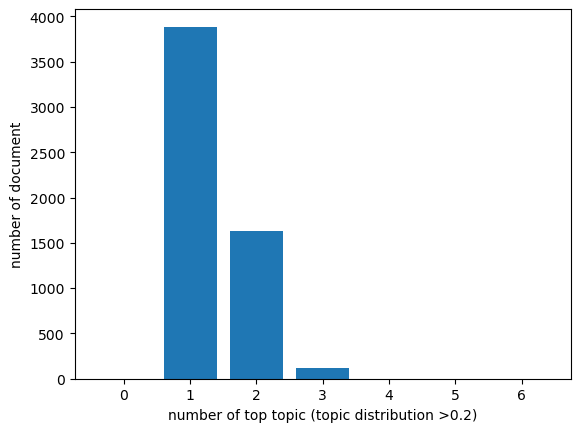

In [27]:
x = ['0','1','2','3','4','5','6']
y = count_num_top_topic
plt.bar(x, y)
plt.xlabel(f'number of top topic (topic distribution >{threshold})')
plt.ylabel('number of document')
plt.show()